<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/FORECASTING(LSTM)65_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap


time = np.arange(0, 500, 1)
data = np.sin(0.02*time) + 0.5*np.sin(0.05*time) + 0.1*np.random.randn(len(time))
df = pd.DataFrame(data, columns=['Target'])
print("Data shape:", df.shape)
df.head()




Data shape: (500, 1)


,Target
0,0.262746
1,0.105096
2,0.208227
3,0.123403
4,0.148297


In [24]:
# STEP 2: SCALE + SEQUENCES
# -----------------------------
SEQ_LEN = 24

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, SEQ_LEN)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print("Train:", X_train.shape, "Test:", X_test.shape)




Train: (380, 24, 1) Test: (96, 24, 1)


In [28]:
def build_model(units=64, dropout=0.2, lr=0.001):
    model = models.Sequential([
        layers.LSTM(units, return_sequences=True, input_shape=(SEQ_LEN,1)),
        layers.Dropout(dropout),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr))
    return model


In [27]:
   model = build_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
!pip install keras-tuner --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.9 MB/s eta 0:00:00


In [90]:
from tensorflow.keras import layers, models

timesteps = X_train.shape[1]
features = X_train.shape[2]

inputs = layers.Input(shape=(timesteps, features))
x = layers.LSTM(64, return_sequences=False)(inputs)
x = layers.Dense(1)(x)
model = models.Model(inputs, x)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
import keras_tuner as kt
print("KerasTuner installed successfully!")


KerasTuner installed successfully!


In [63]:


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# Model builder function for KerasTuner
def build_lstm_model(hp):

    model = models.Sequential()

    # Hyperparameters to search
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')

    model.add(layers.LSTM(
        units,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(layers.Dropout(dropout))

    model.add(layers.LSTM(units))
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )

    return model


# Initialize tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,                   # Try 5 configurations
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='ts_project'
)

print("🔍 Hyperparameter tuning started...")

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[lr_scheduler],
    verbose=1
)

print("✅ Search Complete")

# Best model
best_model = tuner.get_best_models(num_models=1)[0]

print("🔥 Best LSTM Model Summary:")
best_model.summary()


Reloading Tuner from lstm_tuning/ts_project/tuner0.json
🔍 Hyperparameter tuning started...
✅ Search Complete
🔥 Best LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,809 (780.50 KB)

 Trainable params: 199,809 (780.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1284 - val_loss: 0.0199
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0150 - val_loss: 0.0237
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0098 - val_loss: 0.0219
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076 - val_loss: 0.0166
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0066 - val_loss: 0.0082
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053 - val_loss: 0.0074
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051 - val_loss: 0.0077
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0

In [30]:
pred_scaled = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
pred_inv = scaler.inverse_transform(pred_scaled)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


In [31]:
mae = mean_absolute_error(y_test_inv, pred_inv)
rmse = mean_squared_error(y_test_inv, pred_inv)**0.5
print("MAE:", mae, "RMSE:", rmse)

MAE: 0.15954993785730778 RMSE: 0.18729433972079165


In [88]:
# During preprocessing, define target scaler
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = target_scaler.transform(y_test.reshape(-1,1))

# LSTM training uses y_train_scaled
# After prediction:
pred_test = model.predict(X_test)
pred_test_inv = target_scaler.inverse_transform(pred_test).ravel()
y_test_inv   = target_scaler.inverse_transform(y_test_scaled).ravel()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [51]:
y_test_inv = scaler.inverse_transform(y_test)
pred_inv = scaler.inverse_transform(pred_scaled)


In [67]:
def model_predict(flat_input):
    # flat_input shape = (batch, timesteps * features)
    batch = flat_input.shape[0]
    timesteps = X_train.shape[1]
    features = X_train.shape[2]

    reshaped = flat_input.reshape(batch, timesteps, features)

    return model.predict(reshaped)


In [68]:
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype("float32")
X_test_flat  = X_test.reshape(X_test.shape[0], -1).astype("float32")


In [76]:
print("X_train shape =", X_train.shape)
print("background shape =", background.shape)


X_train shape = (379, 24, 4)
background shape = (50, 24, 4)


In [81]:
from tensorflow.keras import layers, models

timesteps = X_train.shape[1]
features  = X_train.shape[2]

inputs = layers.Input(shape=(timesteps, features))
x = layers.LSTM(64, return_sequences=False)(inputs)  # single vector output
x = layers.Dense(1)(x)
model = models.Model(inputs, x)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
sample_idx = np.random.choice(len(X_train), 200)
background = X_train[sample_idx]


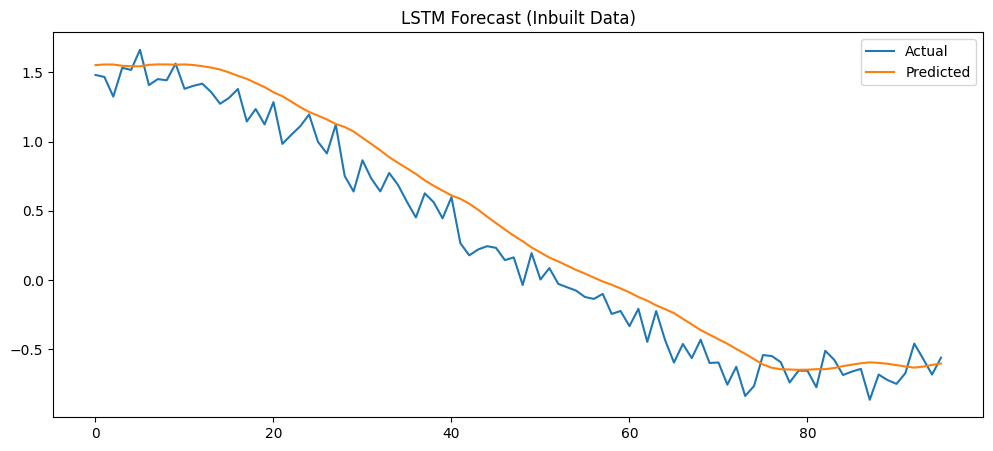

In [32]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='Predicted')
plt.legend()
plt.title("LSTM Forecast (Inbuilt Data)")
plt.show()

In [33]:
def model_predict(x):
    x = np.array(x).reshape(-1, SEQ_LEN, 1)
    return model.predict(x)


In [34]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
explainer = shap.KernelExplainer(model_predict, X_train_flat[:100])
shap_values = explainer.shap_values(X_train_flat[:50])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
shap.summary_plot(shap_values, X_train_flat[:50])

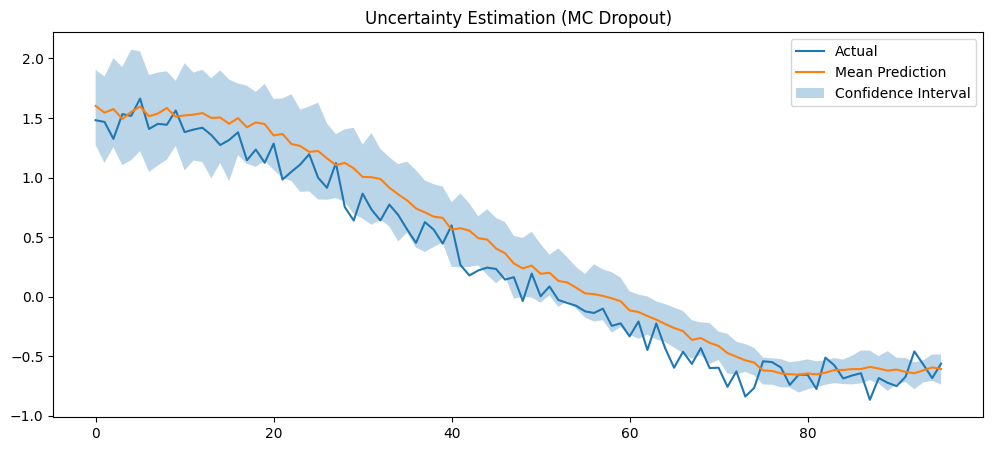

In [41]:
# -----------------------------
# STEP 8: MC DROPOUT UNCERTAINTY (FIXED)
# -----------------------------
def mc_dropout_predict(model, X, n=40):
    preds = []
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    for _ in range(n):
        pred = model(X_tf, training=True).numpy()  # dropout enabled
        preds.append(pred)
    return np.array(preds)

samples = mc_dropout_predict(model, X_test, n=40)
mean_pred = samples.mean(axis=0)
lower = np.percentile(samples, 5, axis=0)
upper = np.percentile(samples, 95, axis=0)

mean_pred_inv = scaler.inverse_transform(mean_pred)
lower_inv = scaler.inverse_transform(lower)
upper_inv = scaler.inverse_transform(upper)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(mean_pred_inv, label="Mean Prediction")
plt.fill_between(
    np.arange(len(mean_pred_inv)),
    lower_inv.flatten(),
    upper_inv.flatten(),
    alpha=0.3, label="Confidence Interval"
)
plt.legend()
plt.title("Uncertainty Estimation (MC Dropout)")
plt.show()


In [52]:
def mc_dropout_predict(model, X, n=40):
    preds = []
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    for _ in range(n):
        pred = model(X_tf, training=True).numpy()  # dropout ON
        preds.append(pred)
    return np.array(preds)


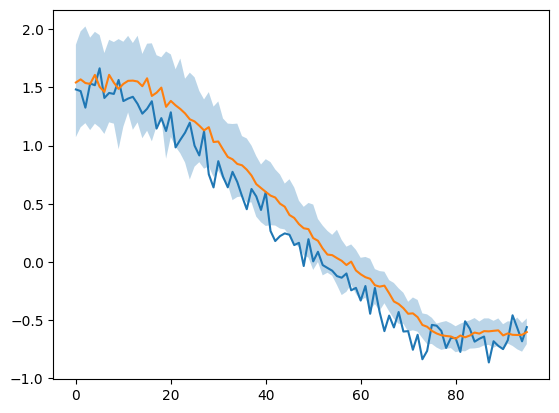

In [53]:
plt.plot(y_test_inv, label="Actual")
plt.plot(mean_pred_inv, label="Mean Prediction")
plt.fill_between(
    range(len(mean_pred_inv)),
    lower_inv.flatten(),
    upper_inv.flatten(),
    alpha=0.3, label="Confidence Interval"
)


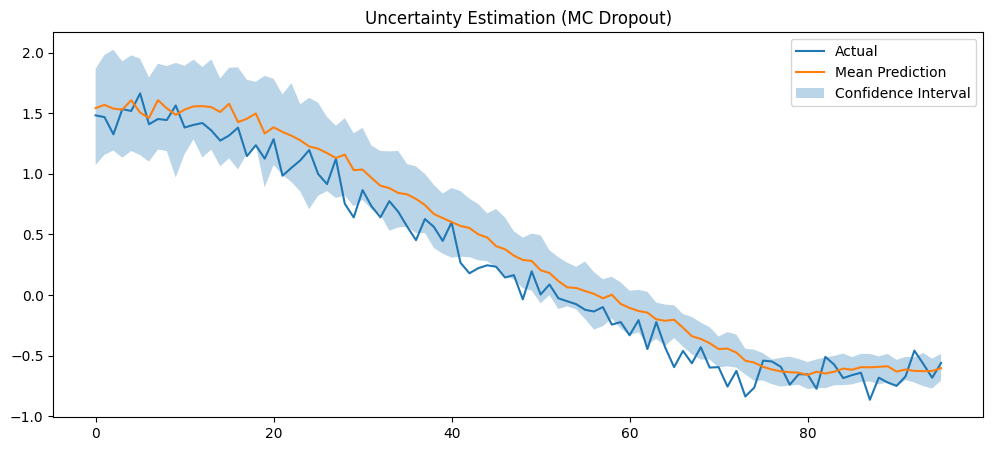

In [45]:
mean_pred_inv = scaler.inverse_transform(mean_pred)
lower_inv = scaler.inverse_transform(lower)
upper_inv = scaler.inverse_transform(upper)

plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(mean_pred_inv, label="Mean Prediction")
plt.fill_between(
    range(len(mean_pred_inv)),
    lower_inv.flatten(),
    upper_inv.flatten(),
    alpha=0.3, label="Confidence Interval"
)
plt.legend()
plt.title("Uncertainty Estimation (MC Dropout)")
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6550/6550 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step
1/1 ━━━━━━━━━━━━

/tmp/ipython-input-912104422.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_flat[:50])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


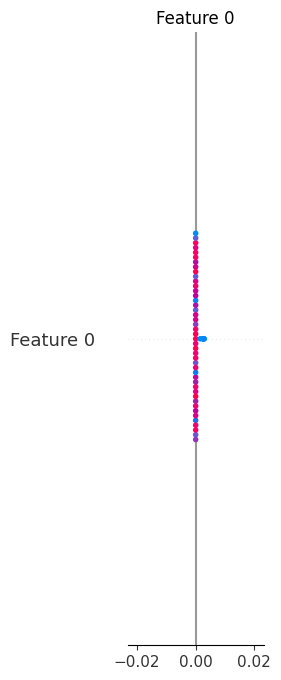

In [54]:
def model_predict(x):
    x = np.array(x).reshape(-1, SEQ_LEN, 1)
    return model.predict(x)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
explainer = shap.KernelExplainer(model_predict, X_train_flat[:100])
shap_values = explainer.shap_values(X_train_flat[:50])
shap.summary_plot(shap_values, X_train_flat[:50])


In [55]:
results_df = pd.DataFrame({
    "Actual": y_test_inv.flatten(),
    "Predicted": mean_pred_inv.flatten(),
    "Lower_95_CI": lower_inv.flatten(),
    "Upper_95_CI": upper_inv.flatten()
})
results_df.to_csv("forecast_results.csv", index=False)


In [46]:
# Save predictions + actual
results_df = pd.DataFrame({
    "Actual": y_test_inv.flatten(),
    "Predicted": mean_pred_inv.flatten(),
    "Lower_95_CI": lower_inv.flatten(),
    "Upper_95_CI": upper_inv.flatten()
})

results_df.to_csv("lstm_forecast_results.csv", index=False)
print("✅ Results saved to lstm_forecast_results.csv")


✅ Results saved to lstm_forecast_results.csv


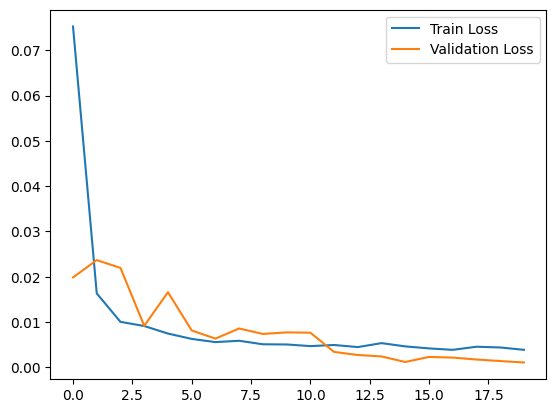

In [56]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()


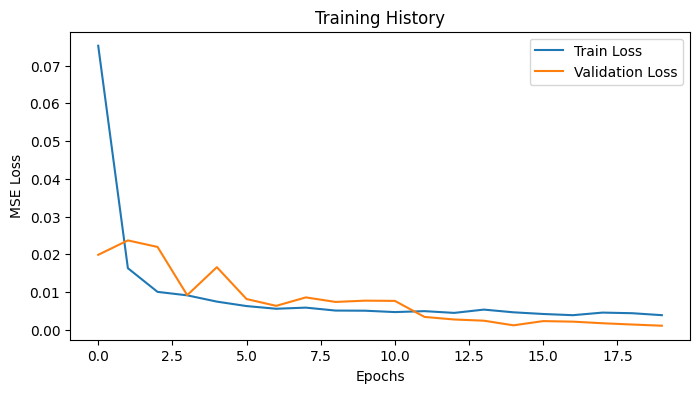

In [47]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [48]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_inv, mean_pred_inv)
print("MAE:", mean_absolute_error(y_test_inv, mean_pred_inv))
print("RMSE:", mean_squared_error(y_test_inv, mean_pred_inv)**0.5)
print("R2 Score:", r2)


MAE: 0.16160469758105397
RMSE: 0.18985688434267176
R2 Score: 0.944368724303727
